In [2]:
# import packages
import cv2
import glob
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio 
import scipy.ndimage as nd 
from scipy.stats import norm
from PIL import Image
import seaborn as sns; sns.set()
import math

In [4]:
# create new color palette similar to enrico's programm
jetBig = cm.get_cmap('jet', 512)
jet_red = ListedColormap(jetBig(np.linspace(0, 0.9, 512)))
gnuplot2 = cm.get_cmap('gnuplot2', 512)
gnuplot2_blue = ListedColormap(gnuplot2(np.linspace(0, 0.125, 512)))
newcolor = np.vstack((gnuplot2_blue(np.linspace(0, 1, 8)), 
                      jet_red(np.linspace(0, 1, 128))))
colorcito = ListedColormap(newcolor, name='Enrico')


# WARNINGS
plt.rcParams.update({'figure.max_open_warning': 0})


# TABLA !
global tabla
tabla = pd.DataFrame(columns = ['treatment', 'cell', 'nucleo/array', 'e', 'int_min', 'int_max', 'obs'])
    
sns.set_style("white")

In [3]:
def read(path):
    
    directory = path + "*.tif"
    
    # read all 150 tif images of one cell
    # glob.glob("path/*.tif") returns a list with all the files .tif in that path
    # cv2.imread() method loads an image from the specified file
    # cv2.IMREAD_UNCHANGED to load the image without any transformation
    img = [cv2.imread(file, cv2.IMREAD_UNCHANGED) for file in glob.glob(directory)]
    
    # see how many images are
    print('total of images before: ' + str(len(img)))

    # print all images 
    '''
    for i in range(len(img)):
        plt.figure()
        plt.imshow(img[i], cmap=colorcito)
        plt.title(str(i))
    '''        
    # remove first 10 images
    del img[:10]
    
    # see how many images are
    print('total of images after: ' + str(len(img)))

    # convert img from list to np.array
    img = np.array(img)
    
    return img

def printFigures(img, title):
    img = np.float32(img)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.savefig('Celulas/train/'+title+'.png', dpi=300,bbox_inches='tight',pad_inches=0) 

def cuentas(S, img, cellcode):   
    # mean of each pixel
    img_mean = np.mean(img, axis=0)
    img_meanS = img_mean/S
    printFigures(img_mean, cellcode)
    
    # variance of each pixel
    img_var = np.var(img, axis=0)
    #printFigures(img_var, 'Variance')
    
    # calculate brightness 
    img_B = img_var/img_mean
    img_BS = img_B/S
    #printFigures(img_B, 'Brightness')
    
    return img_mean, img_meanS, img_BS

def BvsMean(img_meanS, img_BS):
    # flatten B and mean
    flat_img_meanS = img_meanS.flatten()
    flat_img_BS = img_BS.flatten()
    
    # scatter plot B vs mean
    plt.figure()
    plt.xticks(np.arange(0, max(flat_img_meanS), 10))
    plt.scatter(flat_img_meanS, flat_img_BS, s=0.004, c='black')
    plt.title('B vs Intensity')
    plt.xlabel('Instensity')
    plt.ylabel('Brightness')
    
def read_and_calculate(S, path, cellcode):
    img = read(path)
    img_mean, img_meanS, img_BS = cuentas(S, img, cellcode)    
    BvsMean(img_meanS, img_BS)
    return img_mean, img_meanS, img_BS
    
def region(min_B, max_B, min_mean, max_mean, img_meanS, cellcode):
       
    # filter roi
    mask_min_int = img_meanS > min_mean
    mask_max_int = img_meanS < max_mean

    mask_min_B = img_BS > min_B 
    mask_max_B = img_BS <  max_B

    roi = mask_min_int * mask_max_int * mask_min_B * mask_max_B
    roi = roi.astype('uint8')
    fig = plt.figure()
    plt.imshow(roi) 
    plt.axis('off')
    fig.savefig('Celulas/trainannot/'+cellcode+'.png', dpi=300, bbox_inches='tight', pad_inches=0)
    
    # show roi in mean image
             
    img_meanS_reshape = np.reshape(img_meanS, (256, 256, 1)).astype('uint8')
    # creamos nuevos canales para poder visualizar el roi
    img_meanS_reshape = np.repeat(img_meanS_reshape, 3, axis=2)
    # incrementamos la intensidad para que sea vea mejor
    img_meanS_reshape = img_meanS_reshape*10
    
    roi_reshape = np.reshape(roi, (256, 256, 1)).astype('uint8')
    roi_reshape = np.repeat(roi_reshape, 3, axis=2)
    mask_roi = roi_reshape > 0
    roi_rojo = roi_reshape*[255,0,150]
    
    img_meanS_reshape[mask_roi] = roi_rojo[mask_roi]
  
    fig = plt.figure()
    plt.imshow(img_meanS_reshape) 
    plt.title('ROI')
    #fig.savefig('ROI.png', dpi=300)
    
    return roi

def fit(path, lugar, obs, img_BS, roi, min_mean, max_mean):
    # select roi and extract B values
    B2 = roi * img_BS
    flat_img_BS2 = B2.flatten()
    flat_img_BS3 = [i for i in flat_img_BS2 if i != 0 and str(i) != 'nan']
    
    # distplot and fitting
    sns.set_style("white")
    fig = plt.figure()
    a = sns.distplot(flat_img_BS3, fit=norm, kde=False)
    plt.title('Gaussian fitting Brightness ROI')
    plt.xlabel('Brightness')
    plt.ylabel('Frecuency')
    plt.show()
    fig.savefig('Gaussian fitting Brightness ROI.png', dpi=300)
    
    mu, sigma = norm.fit(flat_img_BS3)
    e = mu-1
    
    print('mu: ', mu)
    print('sigma: ', sigma)
    
    table(path, lugar, obs, e, min_mean, max_mean)

def table(path, lugar, obs, e, min_intensity, max_intensity): 
    global tabla
    cell_code = code(path)
    new_row = pd.DataFrame([[cell_code[0], cell_code[1], lugar, e, min_intensity,
    max_intensity, obs]], 
    columns = ['treatment', 'cell', 'nucleo/array', 'e', 'int_min', 'int_max', 'obs'])
    tabla = tabla.append(new_row, ignore_index=True)
    pd.set_option('display.max_columns', None)
    print(tabla)

    
def code(path): 
    
    inv_path = path[::-1]
    cell = ''
    treatment = ''
    glup=''

    i=1
    while inv_path[i] != '/':
        glup =  glup + inv_path[i]
        i+=1
    glup = glup[::-1]+'/'
   
    
    if glup[0].isnumeric():    
        cell, treatment = treatmentAndCell(glup, cell, treatment)
                
    elif not glup[0].isnumeric():    
        treatment, cell = treatmentAndCell(glup, treatment, cell)
        
    cell_code = (treatment, cell)
    return cell_code


def treatmentAndCell(glup, treatment, cell):
    i=0
    while glup[i] != '_':
        treatment = treatment + glup[i]
        i+=1

    i = i+1
    while glup[i] != '/':
        cell =  cell + glup[i]
        i+=1
    return treatment, cell

        
def plot(tabla):
    
    nucleo = tabla[tabla['nucleo/array'] == 'nucleo']
    
    array = tabla[tabla['nucleo/array'] == 'array']
    
    sns.set_palette(sns.color_palette("bright"))
    
    sns.scatterplot(x="int_min", y="e", data=nucleo, hue="trat").set_title("Núcleo")
    plt.show()
    sns.scatterplot(x="int_min", y="e", data=array, hue="trat").set_title("Array")
    plt.show()
    
    sns.set_palette(sns.color_palette("bright")[2:4])
    
    sns.set_style("white")
    fig, ax = plt.subplots()
    sns.boxplot(x="trat", y="e", hue="nucleo/array", data=tabla, ax=ax).set(ylabel='true brightness (e)')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[:], labels=labels[:])


total of images before: 150
total of images after: 140


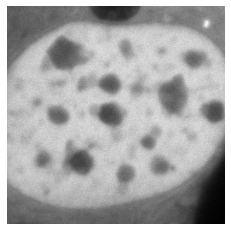

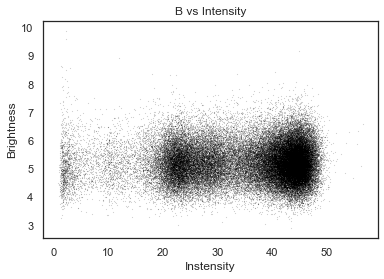

In [223]:
# directorio de la carpeta donde están todas las fotos a medir
# para cambiar de célula de un mismo tratamiento, le cambiás el número
# leer todas fotos de una célula, hacer los cálculos de n&B y ver los gráficos
# pasarle como parámetro el factor S

path = "/home/bruno/Documents/UBA/Reconocimiento de patrones/data TP-final/GPFGRY551A/Y551A 14.oif.files/"
cellcode = 'train_33'
img_mean, img_meanS, img_BS = read_and_calculate(1, path, cellcode)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


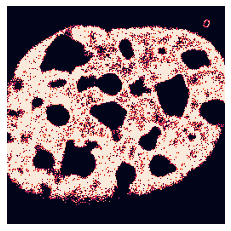

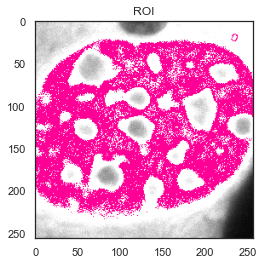

In [226]:
# delimitar la región a medir (núcleo / array)
# los números que hay que poner son la intensidad mínima y máxima

# si se está midiendo Fluoresceina, pasar directamente a la función fit()
min_mean = 40
max_mean = 48
roi = region(4, 8, min_mean, max_mean, img_meanS, cellcode)


/home/bruno/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


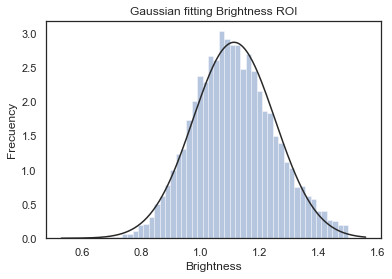

mu:  1.1128685013714243
sigma:  0.13876299205999476
  treatment cell nucleo/array         e int_min int_max obs
0                      nucleo  0.112869       8      12  ok
1      CORT   19       nucleo  0.112869       8      12  ok


In [43]:
fit(path, 'nucleo', 'ok', img_BS, roi, min_mean, max_mean)

In [44]:
tabla

,treatment,cell,nucleo/array,e,int_min,int_max,obs
0,,,nucleo,0.112869,8,12,ok
1,CORT,19,nucleo,0.112869,8,12,ok


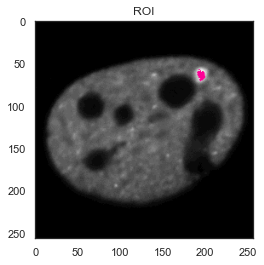

In [45]:
# delimitar la región a medir (núcleo / array)
# los números que hay que poner son la intensidad mínima y máxima

# si se está midiendo Fluoresceina, pasar directamente a la función fit()
min_mean = 20
max_mean = 28
roi = region(0.5, 1.5, min_mean, max_mean, img_meanS)


/home/bruno/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


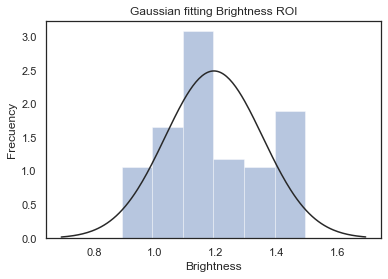

mu:  1.194649467759831
sigma:  0.1602738123419982
  treatment cell nucleo/array         e int_min int_max obs
0                      nucleo  0.112869       8      12  ok
1      CORT   19       nucleo  0.112869       8      12  ok
2      CORT   19        array  0.194649      20      28  ok


In [46]:
fit(path, 'array', 'ok', img_BS, roi, min_mean, max_mean)

In [ ]:
# fittear la gaussiana, extraer los datos y agregarlos a la tabla 
# si estás midiendo núcleo o array lo especificás acá abajo
# donde dice obs es para agregar observaciones

#Fluorescein
fit('-', 'ok', img_BS, roi,min_mean, max_mean)

In [ ]:
# plotear los gráficos con todas las células

plot(tabla)

# guardar tabla con los resultados

tabla.to_csv(r'data/results_CORT.csv', index = False)
